# 本代码功能：
## 将分出主题的内容输出到四个不同的文件夹中
## 对总数据集或分话题数据集按照时间顺序进行情感曲线分析

In [19]:
import pandas as pd
from datetime import datetime
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import re


In [54]:
def data_sort(filename):
    # Create DataFrames for each topic
    df0 = pd.DataFrame(
        {'content': [], 'forward_num': [], 'comment_Num': [], 'like_num': [], 'verify_typ': [], 'publish_time': [],
         'sentiment': []})
    df1 = pd.DataFrame(
        {'content': [], 'forward_num': [], 'comment_num': [], 'like_num': [], 'verify_typ': [], 'publish_time': [],
         'sentiment': []})
    df2 = pd.DataFrame(
        {'content': [], 'forward_num': [], 'comment_num': [], 'like_num': [], 'verify_typ': [], 'publish_time': [],
         'sentiment': []})
    df3 = pd.DataFrame(
        {'content': [], 'forward_num': [], 'comment_num': [], 'like_num': [], 'verify_typ': [], 'publish_time': [],
         'sentiment': []})

    # Read data from the original file
    df = pd.read_csv(filename, encoding="UTF-8", low_memory=False)

    # Loop over each row in the data
    for i in range(len(df)):
        if df.loc[i, "概率最大的主题序号"] == "Topic #0":
            # Append row to df0 DataFrame
            row = pd.DataFrame({
                'content': [df.loc[i, "content"]],
                'forward_num': [df.loc[i, "forward_num"]],
                'comment_num': [df.loc[i, "comment_num"]],
                'like_num': [df.loc[i, "like_num"]],
                'verify_typ': [df.loc[i, "verify_typ"]],
                'publish_time': [df.loc[i, "publish_time"]],
                'sentiment': [df.loc[i, "sentiment"]]
            })
            df0 = pd.concat([df0, row])
        elif df.loc[i, "概率最大的主题序号"] == "Topic #1":
            # Append row to df1 DataFrame
            row = pd.DataFrame({
                'content': [df.loc[i, "content"] + df.loc[i, "content_cutted"] + df.loc[i, "概率最大的主题序号"]],
                'forward_num': [df.loc[i, "forward_num"]],
                'comment_num': [df.loc[i, "comment_num"]],
                'like_num': [df.loc[i, "like_num"]],
                'verify_typ': [df.loc[i, "verify_typ"]],
                'publish_time': [df.loc[i, "publish_time"]],
                'sentiment': [df.loc[i, "sentiment"]]
            })
            df1 = pd.concat([df1, row])
        elif df.loc[i, "概率最大的主题序号"] == "Topic #2":
            # Append row to df2 DataFrame
            row = pd.DataFrame({
                'content': [df.loc[i, "content"] + df.loc[i, "content_cutted"] + df.loc[i, "概率最大的主题序号"]],
                'forward_num': [df.loc[i, "forward_num"]],
                'comment_num': [df.loc[i, "comment_num"]],
                'like_num': [df.loc[i, "like_num"]],
                'verify_typ': [df.loc[i, "verify_typ"]],
                'publish_time': [df.loc[i, "publish_time"]],
                'sentiment': [df.loc[i, "sentiment"]]
            })
            df2 = pd.concat([df2, row])
        elif df.loc[i, "概率最大的主题序号"] == "Topic #3":
            # Append row to df3 DataFrame
            row = pd.DataFrame({
                'content': [df.loc[i, "content"] + df.loc[i, "content_cutted"] + df.loc[i, "概率最大的主题序号"]],
                'forward_num': [df.loc[i, "forward_num"]],
                'comment_num': [df.loc[i, "comment_num"]],
                'like_num': [df.loc[i, "like_num"]],
                'verify_typ': [df.loc[i, "verify_typ"]],
                'publish_time': [df.loc[i, "publish_time"]],
                'sentiment': [df.loc[i, "sentiment"]]
            })
            df3 = pd.concat([df3, row])

    # Write DataFrames to CSV files with column names
    df0.to_csv('/dataset/data_topic0.csv', index=False)  
    df1.to_csv('/dataset/data_topic1.csv', index=False) 
    df2.to_csv('/dataset/data_topic2.csv', index=False)
    df3.to_csv('/dataset/data_topic3.csv', index=False) 

In [55]:
data_sort('/lda/result/data_topic.csv')

In [26]:
def Get_Time(filename):
    df = pd.read_csv(filename,low_memory=False)
    Publish_time = df["publish_time"].astype(str)
    Time = []
    for i in range(len(Publish_time) - 1, -1, -1):
        Time.append(str(Publish_time[i][5:]))
    return Time


In [15]:
#有些数据太大会使得数据为100万+，200万+等，所以需要在计算之前对数据再进行以此处理
def Get_Sentiment(filename):
    df = pd.read_csv(filename,low_memory=False)
    sentiment = df["sentiment"]
    sentiment2 = []
    for i in range(len(sentiment) - 1, -1, -1):
        sentiment2.append(sentiment[i])
    return sentiment2

In [31]:
def Time_Pos(Time,sentiment):
    start_time = datetime.strptime(Time[0], '%m-%d %H:%M')
    seconds = [0]
    for i in range(1, len(Time)):
        time = datetime.strptime(Time[i], '%m-%d %H:%M')
        delta = (time - start_time).total_seconds()
        seconds.append(int(delta // (24 * 60 * 60)))
    count = Counter(seconds)
    index = []
    for i in range(seconds[-1] + 1):
        sum = 0
        for j in range(i + 1):
            sum = sum + count[j]
        index.append(sum)
    Pos_rate = []
    for i in range(seconds[-1] +1):
        good = 0
        for j in range(index[i]):
            if (sentiment[j] == 1):
                good = good + 1
            pos_rate = good / index[i]
        Pos_rate.append(round(pos_rate, 4))
    Pos_rate = Pos_rate[2:]
    seconds[-1] = seconds[-1] - 2
    #从话题出现的48小时后开始统计；前48小时为事件发酵时间，此时情感极性太强，无法提高客观的情感参考
    return seconds,Pos_rate

def fitting_function(x,y):
    X = np.arange(0, x[-1]+1)
    y = np.array(y)
    # 将X升幂到更高的次数，这里我们选择了4次
    poly = PolynomialFeatures(degree=4)
    X_poly = poly.fit_transform(X.reshape(-1, 1))

    # 初始化线性回归模型
    regressor = LinearRegression()

    # 在多项式特征上拟合数据
    regressor.fit(X_poly, y)

    # 预测结果
    y_pred = regressor.predict(X_poly)

    # 绘制拟合结果
    plt.scatter(X, y, color='blue')
    plt.plot(X, y_pred, color='red')
    plt.show()

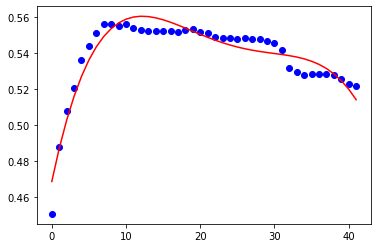

In [53]:
filename = "/lda/result/data_topic.csv"

time = Get_Time(filename)

sentiment = Get_Sentiment(filename)

seconds_pos,Pos_rate = Time_Pos(time,sentiment)

fitting_function(seconds_pos,Pos_rate)